# 网络生成与更改

In [19]:
from matplotlib import pyplot as plt

import pandas as pd

import networkx as nx
from networkx.utils import powerlaw_sequence
import powerlaw

from lib.utils import *

## 生成符合幂律分布的度序列

In [20]:
degree_seq = powerlaw_sequence(10000, exponent=2.5)
int_deg = [int(di) for di in degree_seq]
print(int_deg[:100])

[1, 2, 16, 1, 1, 5, 1, 3, 1, 3, 2, 4, 5, 6, 2, 2, 1, 1, 2, 4, 1, 2, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 2, 1, 6, 1, 13, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 1, 7, 4, 8, 1, 1, 1, 1, 1, 2, 3, 1, 1, 8, 2, 2, 2, 1, 3, 1, 2, 1, 1, 6, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 5, 2, 2, 1, 1, 1, 1, 1, 2, 1]


In [21]:
fit = powerlaw.Fit(int_deg)
print(fit)
kmin = fit.power_law.xmin
print("kmin:", kmin)
print("gamma:", fit.power_law.alpha)
print("D:", fit.power_law.D)

Calculating best minimal value for power law fit
kmin: 12.0
gamma: 2.5175724164249065
D: 0.03913747639293286


<Axes: >

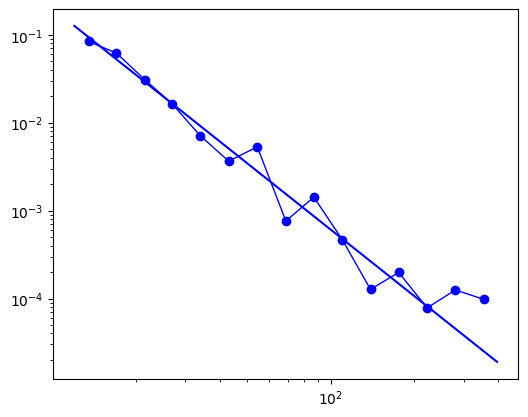

In [22]:
plt.figure(figsize=[6, 4.8])
fig = fit.plot_pdf(marker = 'o', color='b', linewidth=1)
fit.power_law.plot_pdf(color='b', linestyle='-', ax=fig)

## 1、配置模型生成给定度序列的网络

In [23]:
n, gamma = 5000, 2.1
degree_seq = powerlaw_sequence(n, gamma)
int_deg = [int(di) for di in degree_seq]

while sum(int_deg)%2 != 0:
    degree_seq = powerlaw_sequence(n, gamma)
    int_deg = [int(di) for di in degree_seq]
    
    
G = nx.configuration_model(int_deg)
# 该模型会生成自环和多重链接，而这些在真实网络中通常是不会出现的
for e in G.edges():
    if e[0]==e[1]:
        # print(e)
        pass

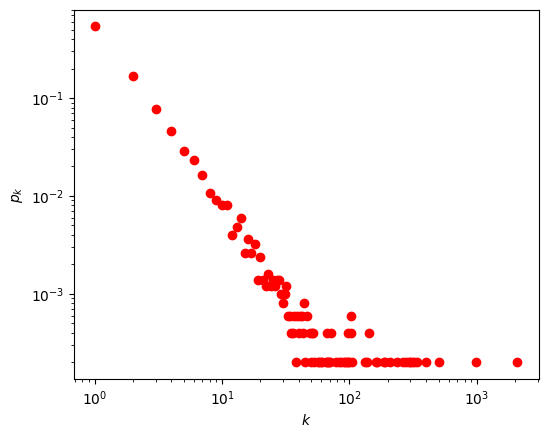

In [24]:
k, Pk = get_pdf(G)
plt.figure(figsize=(6,4.8))
plt.plot(k, Pk, 'ro')
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xscale("log")
plt.yscale("log")

**总结**：配置模型会生成自环和重连边，而这些在真实网络中通常是不会出现的。生成的网络的平均度会随着幂律指数的改变而变化，即平均度不可控

## 2、隐参数模型生成给定度分布指数的无标度网络

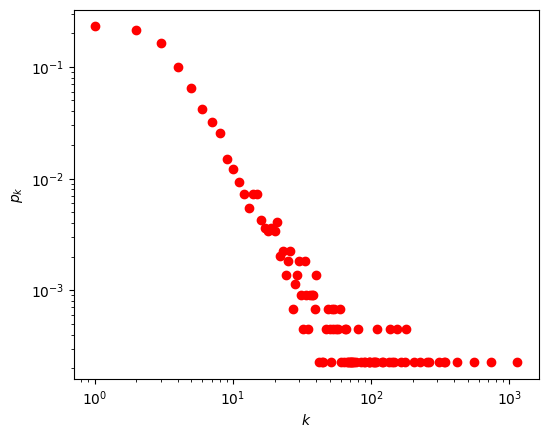

In [25]:
N = 5000
gamma = 2.1
avk = 6.0
L = int(avk*N/2)

G = generate_SF_network(N, gamma, L)
k, Pk = get_pdf(G)
plt.figure(figsize=(6, 4.8))
plt.plot(k, Pk, 'ro')
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xscale("log")
plt.yscale("log")

## 3、度保持的网络随机化

In [26]:
# 加载蛋白质网络数据集
df = pd.read_csv("data/protein_interaction.edgelist.csv")
G = nx.from_pandas_edgelist(df, 'source', 'target', create_using = nx.Graph())
print(len(G.nodes()), len(G.edges()))

2018 2930


1647 2518


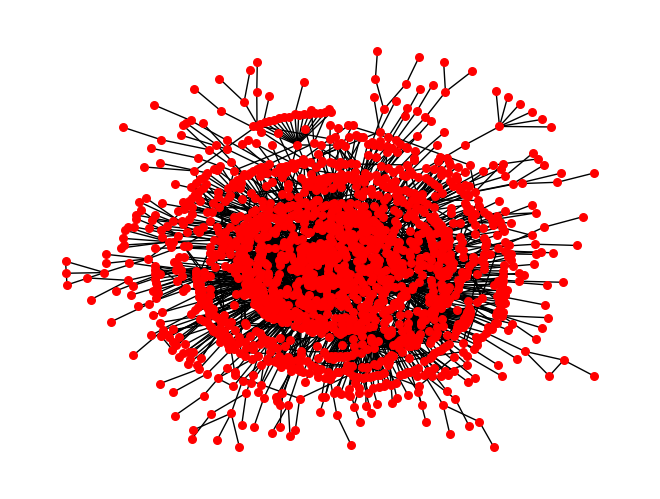

In [27]:
# 删除self-loops
self_edges = []
for e in G.edges():
    if e[0]==e[1]:
        self_edges.append(e)
G.remove_edges_from(self_edges)

Gcc = sorted(nx.connected_components(G), key=len, reverse=True) 
# 得到图G的最大连通组件
LCC = G.subgraph(Gcc[0])

# 获取原始网络的最大连通子图节点数和连边数
N, M = len(LCC.nodes), len(LCC.edges())
print(N, M)
nx.draw(LCC, pos=nx.kamada_kawai_layout(LCC), node_size=30, node_color="red")

0.05659957171711166
0.010697434270878556


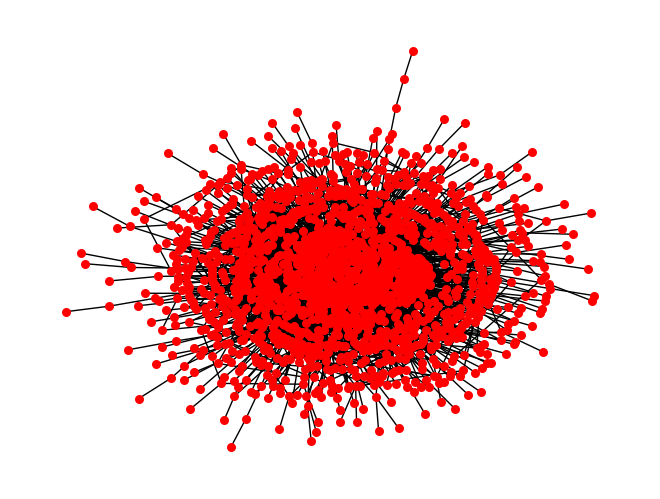

In [28]:
print(nx.average_clustering(LCC))

# 生成度保持的随机化网络：调用double_edge_swap函数
newG = LCC.copy()
G_d = nx.double_edge_swap(newG, nswap=M, max_tries=5*M)
print(nx.average_clustering(G_d))
nx.draw(G_d, pos=nx.kamada_kawai_layout(G_d), node_size=30, node_color="red")

In [29]:
# 生成完全随机化的网络
G_r = nx.gnm_random_graph(N, M)

### 测试小世界性质

Text(0, 0.5, '$p_d$')

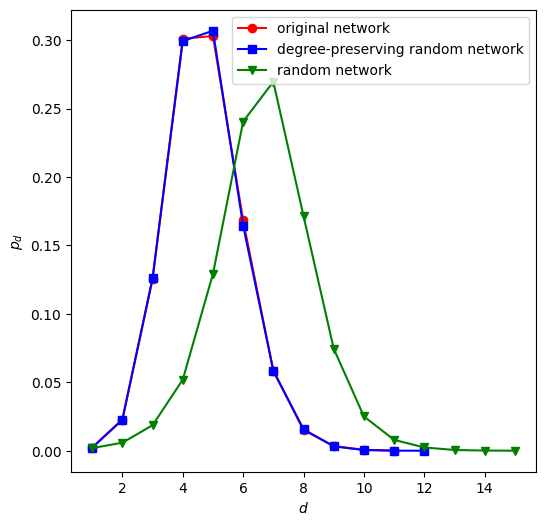

In [30]:
all_sp1, Pl = get_pdf_spl(newG)
all_sp1_d, Pl_d = get_pdf_spl(G_d)
all_sp1_r, Pl_r = get_pdf_spl(G_r)
plt.figure(figsize=(6,6))
plt.plot(all_sp1, Pl, 'ro-', label='original network')
plt.plot(all_sp1_d, Pl_d, 'bs-', label='degree-preserving random network')
plt.plot(all_sp1_r, Pl_r, 'gv-', label='random network')
plt.legend(loc=0)
plt.xlabel("$d$")
plt.ylabel("$p_d$")

In [31]:
print(nx.is_connected(LCC))
print(nx.is_connected(G_d))

True
False


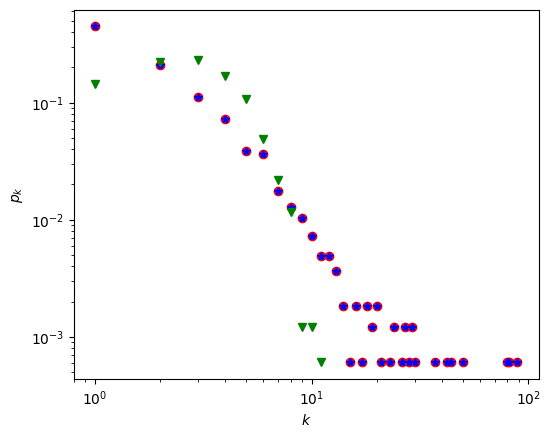

In [32]:
k1, Pk1 = get_pdf(LCC)
k2, Pk2 = get_pdf(G_d)
k3, Pk3 = get_pdf(G_r)
plt.figure(figsize=(6, 4.8))
plt.plot(k1, Pk1, 'ro')
plt.plot(k2, Pk2, 'b*')
plt.plot(k3, Pk3, 'gv')
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.xscale("log")
plt.yscale("log")